# DATA

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
voc_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform)
train_loader = DataLoader(voc_dataset, batch_size=8, shuffle=True)

100%|██████████████████████| 1999639040/1999639040 [07:32<00:00, 4418948.57it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

In [91]:
def data_show(idx):
    image, mask = voc_dataset[idx]
    mask = np.array(mask)
    mask[mask == 255] = 0
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.title("Input Image")
    
    plt.subplot(1,2,2)
    plt.title("Segmentation Mask")
    plt.imshow(mask, cmap="tab20")
    plt.axis('off')
    
    plt.show()

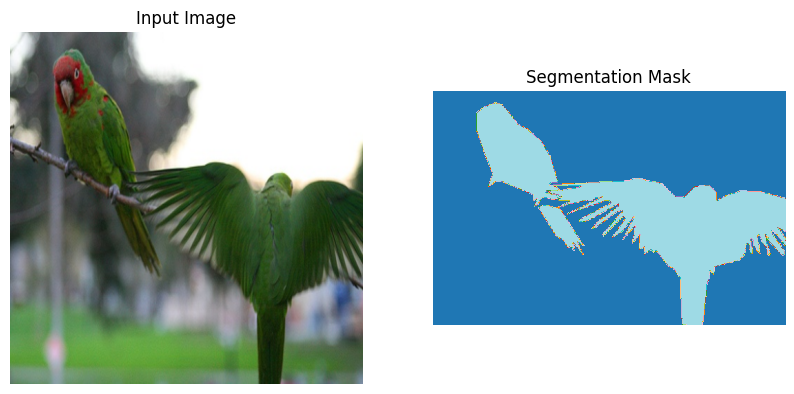

In [94]:
data_show(11)

# Model

In [95]:
import torch
import torch.nn as nn
import torchvision.models as models

In [97]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()

        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features

        self.conv1x1 = nn.Conv2d(512, num_classes, kernel_size=1)

        self.upconv32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

    def forward(self, x):
        x = self.features(x)
        x = self.conv1x1(x)
        x = self.upconv32(x)
        return x

In [98]:
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import numpy as np
import torch

# 이미지 전처리 (Normalize 적용)
transform_img = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained 모델 사용 시 필요
])

# 마스크 전처리 (255 유지)
transform_mask = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))  # 정수형 유지
])

# VOC 데이터셋 클래스 (transform을 개별 적용)
class VOCDataset(VOCSegmentation):
    def __getitem__(self, index):
        img, mask = super().__getitem__(index)
        img = transform_img(img)  # 이미지 변환
        mask = transform_mask(mask)  # 마스크 변환 (정수)
        return img, mask

# DataLoader 설정
train_dataset = VOCDataset(root="./data", year="2012", image_set="train", download=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
# 손실 함수 (255 무시)
criterion = nn.CrossEntropyLoss(ignore_index=255)

# 옵티마이저 (Adam 사용)
model = FCN32s(num_classes=21).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/jinjinjara1022/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jinjinjara1022/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [101]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # 모델 예측
            outputs = model(images)  # (Batch, 21, 512, 512)
            
            # 손실 계산 (CrossEntropyLoss는 (Batch, num_classes, H, W) + (Batch, H, W) 형태 필요)
            loss = criterion(outputs, masks)

            # 역전파 & 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training Completed!")

# 모델 학습 시작
train(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 1.2380
Epoch [2/10], Loss: 0.8246
Epoch [3/10], Loss: 0.6888
Epoch [4/10], Loss: 0.5922
Epoch [5/10], Loss: 0.5205
Epoch [6/10], Loss: 0.4589
Epoch [7/10], Loss: 0.3935
Epoch [8/10], Loss: 0.3481
Epoch [9/10], Loss: 0.2961
Epoch [10/10], Loss: 0.2351
Training Completed!


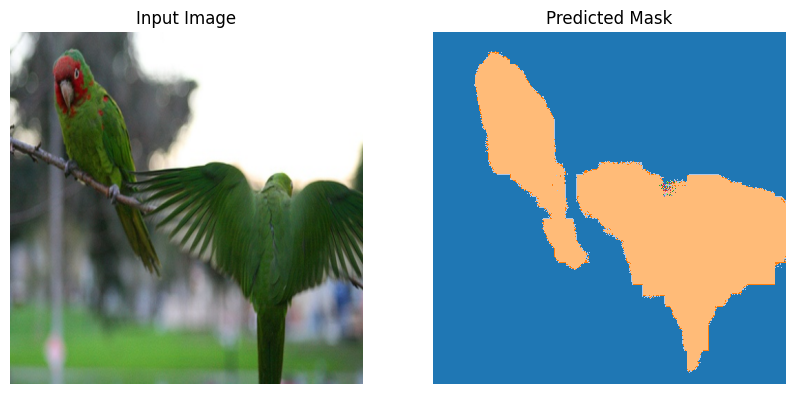

In [108]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, index=0):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image, mask = dataset[index]
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가

    with torch.no_grad():
        output = model(image)  # 예측 수행
        pred_mask = torch.argmax(output, dim=1).cpu().squeeze(0).numpy()  # 클래스별 예측

    # 원본 이미지 & 예측 마스크 시각화
    or_image = voc_dataset[index][0]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(or_image.cpu().squeeze().permute(1,2,0))
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(pred_mask, cmap="tab20")
    plt.axis('off')
    plt.title("Predicted Mask")

    plt.show()

# 모델 평가 (랜덤 이미지)
visualize_prediction(model, train_dataset, index=11)